In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/Shareddrives/DeepLearning/DeepLearning_2021/Final_Project/segmentation_models.pytorch')

!pip install pretrainedmodels
!pip install efficientnet_pytorch
!pip install timm

import torch
import numpy as np
import segmentation_models_pytorch as smp # we import the corresponding models from drive 

!pip install -U git+https://github.com/albu/albumentations --no-cache-dir # it's needed so albu has atribute Lambda

import os # we need this to import the data
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import albumentations as albu
from segmentation_models_pytorch.encoders import get_preprocessing_fn

import cv2
import matplotlib.pyplot as plt

# import librarys for data manipulation
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset


Mounted at /content/drive
     |████████████████████████████████| 61kB 2.9MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=8c9fb033667975527b73df9e2b66caa6158a1316b1622c50b7f9fa120fea604e
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=e974ccb6bca46df2c8bd53218954d0cb027605581c6757d0516836ed9bc28f05
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch
     |████████████████████████████████| 348kB 4.0MB/s 
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-4fnsug6j
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-4fnsug6j
  Created wheel for albumentations: filename=al

In [ ]:
DATA_DIR = './data/CamVid/'

# load repository with data
os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')

32768

In [ ]:
# Split data in input and labels for training and testing
x_train_dir = os.path.join(DATA_DIR, 'train') # input train data
y_train_dir = os.path.join(DATA_DIR, 'trainannot') # labels train data 

x_test_dir = os.path.join(DATA_DIR, 'test') # input test data
y_test_dir = os.path.join(DATA_DIR, 'testannot') # labels test data

In [ ]:
# Function for data visualization
def visualize(**images):
    #PLot images in one row
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
# Class for data extraction, transformation and preprocessing
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. normalization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None, 
            preprocessing=None):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert string names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float') 
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [ ]:
# Data aumentation, by applying transformations in order to prevent overfitting
def get_training_augmentation():
    train_transform = [
       
        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, 
                              p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, 
                         border_mode=0),
                       
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
                albu.RandomContrast(p=1),
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),  
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),]
                
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [albu.PadIfNeeded(384, 480)]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    # To normalize the data
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
# Create the model 
ENCODER = 'vgg11'   # choose encoder
ENCODER_WEIGHTS = 'imagenet'   # use `imagenet` pre-trained weights for encoder initialization
CLASSES = ['car']   # model output channels (number of classes in your dataset)
ACTIVATION = 'sigmoid'  # Activation function at each layer
DEVICE = 'cuda' # We need the GPU to train this models

# create segmentation model with pretrained encoder
model = smp.Linknet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth


In [ ]:
# We define the training dataset  
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1727: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning:

In [ ]:
loss = smp.utils.losses.L1Loss()  
metrics = [smp.utils.metrics.Accuracy(threshold=0.5)] 
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])  

In [ ]:
# create epoch runners, with a loop that iterates over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 100 epochs
train_logs = []
for i in range(0, 100):
    print('\nEpoch: {}'.format(i))
    train_logs.append(train_epoch.run(train_loader))


Epoch: 0
train:   0%|          | 0/46 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: 100%|██████████| 46/46 [00:29<00:00,  1.58it/s, l1_loss - 0.4124, accuracy - 0.6978]

Epoch: 1
train: 100%|██████████| 46/46 [00:28<00:00,  1.59it/s, l1_loss - 0.2509, accuracy - 0.918]

Epoch: 2
train: 100%|██████████| 46/46 [00:28<00:00,  1.60it/s, l1_loss - 0.1835, accuracy - 0.9676]

Epoch: 3
train: 100%|██████████| 46/46 [00:28<00:00,  1.59it/s, l1_loss - 0.1571, accuracy - 0.9717]

Epoch: 4
train: 100%|██████████| 46/46 [00:28<00:00,  1.64it/s, l1_loss - 0.139, accuracy - 0.9783]

Epoch: 5
train: 100%|██████████| 46/46 [00:28<00:00,  1.63it/s, l1_loss - 0.1245, accuracy - 0.9799]

Epoch: 6
train: 100%|██████████| 46/46 [00:28<00:00,  1.60it/s, l1_loss - 0.1166, accuracy - 0.9786]

Epoch: 7
train: 100%|██████████| 46/46 [00:28<00:00,  1.61it/s, l1_loss - 0.1068, accuracy - 0.9813]

Epoch: 8
train: 100%|██████████| 46/46 [00:28<00:00,  1.63it/s, l1_loss - 0.0991, accuracy - 0.9841]

Epoch: 9
train: 100%|██████████| 46/46 [00:28<00:00,  1.63it/s, l1_loss - 0.0918, accuracy - 

Text(0, 0.5, 'Loss Val')

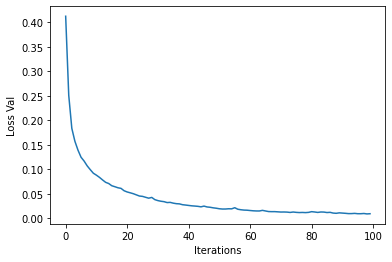

In [ ]:
# Train loss
loss_array = np.zeros(100)
for i in range(0, 100):
  loss_array[i]=train_logs[i]['l1_loss']

# Loss function graphic
plt.figure()
plt.plot(loss_array)
plt.xlabel('Iterations')
plt.ylabel('Loss Val')


In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 233/233 [00:18<00:00, 12.87it/s, l1_loss - 0.01076, accuracy - 0.9916]


In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(x_test_dir, y_test_dir, classes=CLASSES)

In [ ]:
print(logs) # logs computes both the loss and the accuracy of the model

{'l1_loss': 0.01075746098737125, 'accuracy': 0.9916280610366957}


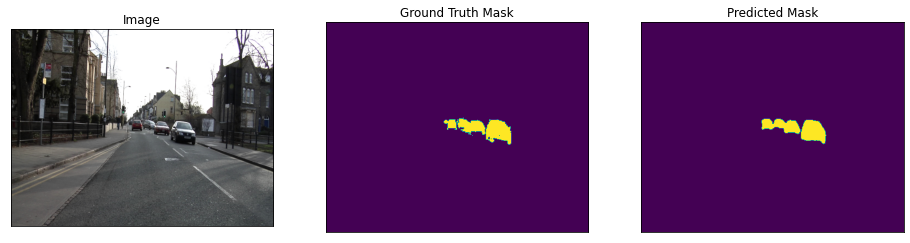

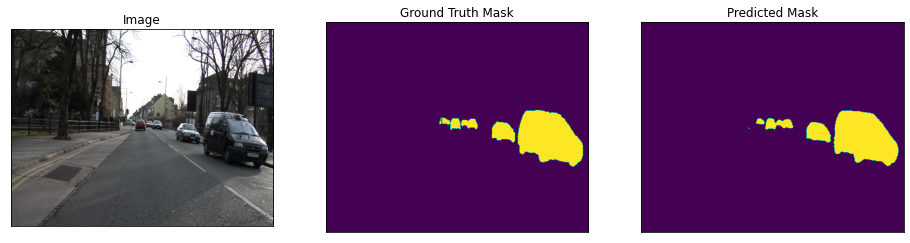

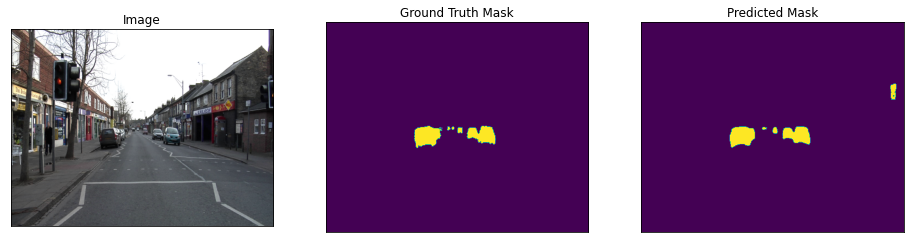

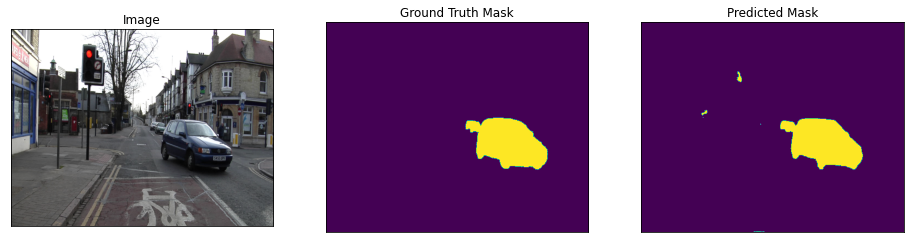

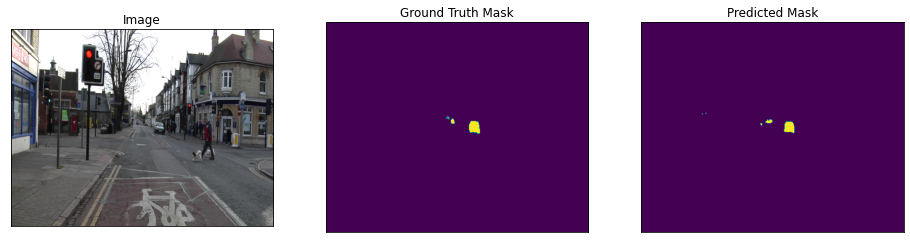

In [ ]:
 # Compare the result of the model with the ground truth
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask)
